In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt 
import matplotlib 
%matplotlib inline

In [2]:
img = cv2.imread('Five_Faces/musk/musk0.jpg')

In [3]:
img.shape

(695, 474, 3)

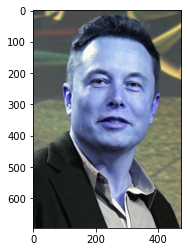

In [4]:
plt.imshow(img)

In [5]:
gray = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)

In [6]:
gray.shape


(695, 474)

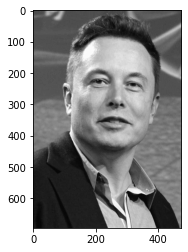

In [7]:
plt.imshow(gray , cmap = 'gray')

In [8]:
face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_eye.xml')

In [9]:
faces = face_cascade.detectMultiScale(gray , 1.3 , 5)
faces

array([[108, 109, 307, 307]])

In [10]:
(x , y , w , h) = faces[0]
x , y,  w , h

(108, 109, 307, 307)

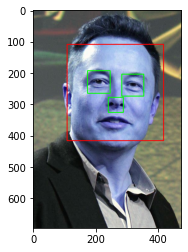

In [11]:
cv2.destroyAllWindows()
for (x , y , w, h) in faces :
    face_img = cv2.rectangle(img , (x , y) , (x + w , y + h), (255 , 0 , 0) , 2)
    roi_gray = gray[y:y + h , x:x+w]
    roi_color = face_img[y:y + h , x: x + w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex , ey , ew , eh) in eyes :
        cv2.rectangle(roi_color , (ex , ey) , (ex + ew , ey + eh) , (0 ,255 , 0) , 2)
        
plt.figure()
plt.imshow(face_img , cmap = "gray")
plt.show()

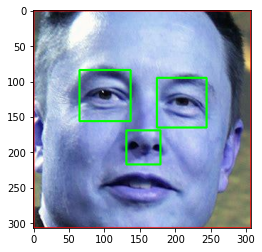

In [12]:
plt.imshow(roi_color , cmap = "gray")

In [13]:
def get_cropped_image(image_path):
    """
    This function helps to us select and crop those images which contain 2 eyes 
    """
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray  , 1.3 , 5)
    for (x , y , w , h) in faces :
        roi_gary = gray[y:y+h , x:x+w]
        roi_color = img[y:y+h , x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2 :
            return roi_color
        
        

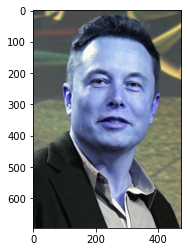

In [14]:
original_image = cv2.imread('Five_Faces/musk/musk0.jpg')
plt.imshow(original_image)

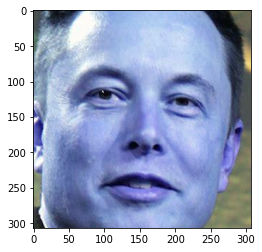

In [15]:
cropped_image = get_cropped_image('Five_Faces/musk/musk0.jpg')
plt.imshow(cropped_image)

In [16]:
data_path = 'Five_Faces/'
cropped_img_path = 'Five_Faces/cropped/'

In [17]:
import os
img_dirs = []
for entry in os.scandir(data_path):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [18]:
img_dirs

['Five_Faces/gates',
 'Five_Faces/jack',
 'Five_Faces/modi',
 'Five_Faces/musk',
 'Five_Faces/trump']

In [19]:
import shutil
if os.path.exists(cropped_img_path):
    shutil.rmtree(cropped_img_path)
os.mkdir(cropped_img_path)

In [20]:
cropped_image_dirs = []
face_names = {}

for img_dir in img_dirs :
    count = 1
    face_name = img_dir.split('/')[-1]
    print(face_name)
    face_names[face_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image(entry.path)
        if roi_color is not None :
            cropped_folder = cropped_img_path + face_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder : " , cropped_folder)
            
            cropped_file_name = face_name + str(count) + '.png'
            cropped_file_path = cropped_folder + '/' + cropped_file_name
            cv2.imwrite(cropped_file_path , roi_color)
            face_names[face_name].append(cropped_file_path)
            count += 1

gates
Generating cropped images in folder :  Five_Faces/cropped/gates
jack
Generating cropped images in folder :  Five_Faces/cropped/jack
modi
Generating cropped images in folder :  Five_Faces/cropped/modi
musk
Generating cropped images in folder :  Five_Faces/cropped/musk
trump
Generating cropped images in folder :  Five_Faces/cropped/trump


In [21]:

import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

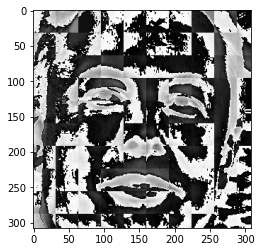

In [22]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap='gray')

In [23]:
class_dict = {}
count = 0 
for face_name in face_names.keys():
    class_dict[face_name] = count 
    count += 1
class_dict 

{'gates': 0, 'jack': 1, 'modi': 2, 'musk': 3, 'trump': 4}

In [24]:
x , y = [] , []
for face_name , training_files in face_names.items() :
    for training_image in training_files : 
        img = cv2.imread(training_image)
        raw_img = cv2.resize(img , (32 , 32))
        img_har = w2d(img , 'db1' , 5)
        scalled_img_har = cv2.resize(img_har , (32 , 32))
        combined_img = np.vstack((raw_img.reshape(32*32*3 , 1) , scalled_img_har.reshape(32*32 , 1)))
        x.append(combined_img)
        y.append(class_dict[face_name])

# USING DIFFERENT MODELS WITH BEST FINE TUNED PARAMETERS

In [25]:
(len(x[0]) == 32*32*3 + 32*32)
len(x)

506

In [26]:
x = np.array(x).reshape(len(x) , 4096).astype(float)
x.shape

(506, 4096)

In [27]:
from sklearn.svm import SVC 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [28]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8976377952755905

In [29]:
pipe.score(X_test , y_test)


0.8976377952755905

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, model.predict(X_test))
from sklearn.metrics import classification_report
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        20
           1       0.86      0.92      0.89        26
           2       0.95      0.86      0.90        21
           3       0.86      0.97      0.91        37
           4       1.00      0.87      0.93        23

    accuracy                           0.90       127
   macro avg       0.91      0.88      0.89       127
weighted avg       0.90      0.90      0.90       127



In [34]:

import joblib 
# Save the model as a pickle in a file 
joblib.dump(model, 'model/model.pkl') 

['model/model.pkl']

In [35]:
class_dict

{'gates': 0, 'jack': 1, 'modi': 2, 'musk': 3, 'trump': 4}

In [36]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [37]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.841860,"{'svc__C': 10, 'svc__kernel': 'rbf'}"
1,random_forest,0.672842,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.870737,{'logisticregression__C': 1}


In [38]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(C=10, gamma='auto', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [39]:
best_estimators['svm'].score(X_test,y_test)

0.8976377952755905

In [40]:
best_clf = best_estimators['svm']

In [42]:
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'model\model.pkl')

['model\\model.pkl']